In [1]:
import pandas as pd
import numpy as np
import keras_contrib
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
import csv
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(10)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence

Using TensorFlow backend.


In [2]:
tsvfile=open("NCBI-disease-IOB/train.tsv",encoding="utf-8")
tsvreader = csv.reader(tsvfile, delimiter="\t")
data=[]
sentences=[]
words=[]
tags=[]
maxsentlen=0
for line in tsvreader:
    if line!=[]:
        data.append(line)
        if line[0] not in words:
            words.append(line[0])
        if line[1] not in tags:
            tags.append(line[1])
    else:
        sentences.append(data)
        if maxsentlen<len(data):
            maxsentlen=len(data)
        data=[]

In [3]:
print(len(sentences))
print(len(words))

5422
9307


In [4]:
word_to_index = {w : i + 2 for i, w in enumerate(words)}
print(word_to_index[words[0]])
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
print(tag_to_index[tags[0]])

tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
print(idx2word[2])
idx2tag = {i: w for w, i in tag_to_index.items()}
print(len(tag_to_index))

2
1
Identification
4


In [5]:
# Number of data points passed in each iteration
batch_size =50
# Passes through entire dataset
epochs = 10
# Maximum length of review
max_len = maxsentlen+15
# Dimension of embedding vector
embedding = 200

In [6]:
X = [[word_to_index[w[0]] for w in s] for s in sentences]
print(X[0],X[1])
count=0
for s in sentences:
    print(s)
    count=count+1
    if count>5:
        break
# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

[2, 3, 4, 5, 6, 7, 3, 8, 9, 10, 11, 12, 13, 14] [15, 9, 10, 11, 16, 17, 18, 12, 19, 13, 20, 21, 8, 22, 23, 24, 25, 26, 6, 27, 28, 29, 30, 31, 32, 16, 33, 19, 32, 18, 5, 34, 35, 36, 37, 38, 14]
[['Identification', 'O'], ['of', 'O'], ['APC2', 'O'], [',', 'O'], ['a', 'O'], ['homologue', 'O'], ['of', 'O'], ['the', 'O'], ['adenomatous', 'B-Disease'], ['polyposis', 'I-Disease'], ['coli', 'I-Disease'], ['tumour', 'I-Disease'], ['suppressor', 'O'], ['.', 'O']]
[['The', 'O'], ['adenomatous', 'B-Disease'], ['polyposis', 'I-Disease'], ['coli', 'I-Disease'], ['(', 'I-Disease'], ['APC', 'I-Disease'], [')', 'I-Disease'], ['tumour', 'I-Disease'], ['-', 'O'], ['suppressor', 'O'], ['protein', 'O'], ['controls', 'O'], ['the', 'O'], ['Wnt', 'O'], ['signalling', 'O'], ['pathway', 'O'], ['by', 'O'], ['forming', 'O'], ['a', 'O'], ['complex', 'O'], ['with', 'O'], ['glycogen', 'O'], ['synthase', 'O'], ['kinase', 'O'], ['3beta', 'O'], ['(', 'O'], ['GSK', 'O'], ['-', 'O'], ['3beta', 'O'], [')', 'O'], [',', 'O']

In [7]:
print(X[0])
len(X[0])

[ 2  3  4  5  6  7  3  8  9 10 11 12 13 14  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


138

In [8]:
# Convert label to index
y = [[tag_to_index[w[1]] for w in s] for s in sentences]
print(y[0])
# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

[1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 1, 1]


In [9]:
num_tag = 3
print(num_tag)
# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]
print(y[0][1],y[0][18])
print(len(y[0][1]))

3
[0. 1. 0. 0.] [1. 0. 0. 0.]
4


In [10]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])
len(X[0])

*****Before Processing first sentence : *****
 Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .
*****After Processing first sentence : *****
  [ 2  3  4  5  6  7  3  8  9 10 11 12 13 14  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


138

In [11]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[1] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 O O O O O O O O B-Disease I-Disease I-Disease I-Disease O O
*****After Processing first sentence : *****
  [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0

In [12]:
num_tags = 3
# Model architecture
input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = True)(input)
model = Bidirectional(LSTM(units = 100, return_sequences=True, recurrent_dropout=0.1))(model)
crf = CRF(num_tags+1)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

#model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

In [14]:
history = model.fit(X, np.array(y), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 4879 samples, validate on 543 samples
Epoch 1/10
4879/4879 [==============================] - ETA: 5:29 - loss: 8.8182 - crf_viterbi_accuracy: 0.01 - ETA: 3:14 - loss: 8.6130 - crf_viterbi_accuracy: 0.01 - ETA: 2:27 - loss: 9.6587 - crf_viterbi_accuracy: 0.01 - ETA: 2:04 - loss: 10.1587 - crf_viterbi_accuracy: 0.163 - ETA: 1:51 - loss: 9.7002 - crf_viterbi_accuracy: 0.318 - ETA: 1:41 - loss: 9.4490 - crf_viterbi_accuracy: 0.41 - ETA: 1:34 - loss: 9.6722 - crf_viterbi_accuracy: 0.48 - ETA: 1:29 - loss: 9.6023 - crf_viterbi_accuracy: 0.53 - ETA: 1:25 - loss: 9.5119 - crf_viterbi_accuracy: 0.58 - ETA: 1:21 - loss: 9.6009 - crf_viterbi_accuracy: 0.61 - ETA: 1:18 - loss: 9.5779 - crf_viterbi_accuracy: 0.64 - ETA: 1:16 - loss: 9.6409 - crf_viterbi_accuracy: 0.66 - ETA: 1:13 - loss: 9.7197 - crf_viterbi_accuracy: 0.68 - ETA: 1:12 - loss: 9.7043 - crf_viterbi_accuracy: 0.69 - ETA: 1:10 - loss: 9.6082 - crf_viterbi_accuracy: 0.71 - ETA: 1

4879/4879 [==============================] - ETA: 1:18 - loss: 7.8067 - crf_viterbi_accuracy: 0.95 - ETA: 1:16 - loss: 7.9056 - crf_viterbi_accuracy: 0.95 - ETA: 1:15 - loss: 8.2158 - crf_viterbi_accuracy: 0.95 - ETA: 1:15 - loss: 9.1062 - crf_viterbi_accuracy: 0.96 - ETA: 1:14 - loss: 8.9467 - crf_viterbi_accuracy: 0.96 - ETA: 1:13 - loss: 9.1413 - crf_viterbi_accuracy: 0.95 - ETA: 1:12 - loss: 8.9944 - crf_viterbi_accuracy: 0.96 - ETA: 1:11 - loss: 9.0328 - crf_viterbi_accuracy: 0.96 - ETA: 1:10 - loss: 9.3311 - crf_viterbi_accuracy: 0.96 - ETA: 1:09 - loss: 9.6646 - crf_viterbi_accuracy: 0.95 - ETA: 1:09 - loss: 9.8154 - crf_viterbi_accuracy: 0.95 - ETA: 1:08 - loss: 9.6677 - crf_viterbi_accuracy: 0.96 - ETA: 1:07 - loss: 9.6130 - crf_viterbi_accuracy: 0.95 - ETA: 1:06 - loss: 9.6783 - crf_viterbi_accuracy: 0.95 - ETA: 1:05 - loss: 9.5203 - crf_viterbi_accuracy: 0.95 - ETA: 1:05 - loss: 9.4626 - crf_viterbi_accuracy: 0.95 - ETA: 1:04 - loss: 9.4515 - crf_viterbi_accuracy: 0.95 - ETA

4879/4879 [==============================] - ETA: 1:19 - loss: 11.1137 - crf_viterbi_accuracy: 0.977 - ETA: 1:18 - loss: 9.8389 - crf_viterbi_accuracy: 0.978 - ETA: 1:17 - loss: 8.8201 - crf_viterbi_accuracy: 0.98 - ETA: 1:17 - loss: 8.4620 - crf_viterbi_accuracy: 0.98 - ETA: 1:17 - loss: 9.0511 - crf_viterbi_accuracy: 0.97 - ETA: 1:16 - loss: 9.2127 - crf_viterbi_accuracy: 0.97 - ETA: 1:14 - loss: 9.2881 - crf_viterbi_accuracy: 0.97 - ETA: 1:13 - loss: 9.4724 - crf_viterbi_accuracy: 0.97 - ETA: 1:12 - loss: 9.6580 - crf_viterbi_accuracy: 0.97 - ETA: 1:11 - loss: 9.6150 - crf_viterbi_accuracy: 0.97 - ETA: 1:11 - loss: 9.6068 - crf_viterbi_accuracy: 0.97 - ETA: 1:10 - loss: 9.6386 - crf_viterbi_accuracy: 0.97 - ETA: 1:09 - loss: 9.4239 - crf_viterbi_accuracy: 0.97 - ETA: 1:08 - loss: 9.3744 - crf_viterbi_accuracy: 0.97 - ETA: 1:07 - loss: 9.3314 - crf_viterbi_accuracy: 0.97 - ETA: 1:06 - loss: 9.2617 - crf_viterbi_accuracy: 0.97 - ETA: 1:06 - loss: 9.1570 - crf_viterbi_accuracy: 0.97 - 

4879/4879 [==============================] - ETA: 1:21 - loss: 8.6237 - crf_viterbi_accuracy: 0.98 - ETA: 1:19 - loss: 8.7847 - crf_viterbi_accuracy: 0.98 - ETA: 1:18 - loss: 8.2631 - crf_viterbi_accuracy: 0.98 - ETA: 1:17 - loss: 8.5375 - crf_viterbi_accuracy: 0.98 - ETA: 1:16 - loss: 8.7916 - crf_viterbi_accuracy: 0.98 - ETA: 1:15 - loss: 8.8612 - crf_viterbi_accuracy: 0.97 - ETA: 1:14 - loss: 8.8376 - crf_viterbi_accuracy: 0.98 - ETA: 1:13 - loss: 9.1205 - crf_viterbi_accuracy: 0.98 - ETA: 1:13 - loss: 9.0024 - crf_viterbi_accuracy: 0.98 - ETA: 1:12 - loss: 9.2655 - crf_viterbi_accuracy: 0.98 - ETA: 1:11 - loss: 9.1276 - crf_viterbi_accuracy: 0.98 - ETA: 1:11 - loss: 9.4238 - crf_viterbi_accuracy: 0.98 - ETA: 1:10 - loss: 9.5549 - crf_viterbi_accuracy: 0.98 - ETA: 1:10 - loss: 9.3790 - crf_viterbi_accuracy: 0.98 - ETA: 1:09 - loss: 9.3487 - crf_viterbi_accuracy: 0.98 - ETA: 1:09 - loss: 9.3209 - crf_viterbi_accuracy: 0.98 - ETA: 1:08 - loss: 9.3949 - crf_viterbi_accuracy: 0.98 - ETA

4879/4879 [==============================] - ETA: 1:23 - loss: 7.7247 - crf_viterbi_accuracy: 0.98 - ETA: 1:19 - loss: 8.7924 - crf_viterbi_accuracy: 0.99 - ETA: 1:18 - loss: 8.8738 - crf_viterbi_accuracy: 0.99 - ETA: 1:16 - loss: 8.7958 - crf_viterbi_accuracy: 0.99 - ETA: 1:15 - loss: 8.9913 - crf_viterbi_accuracy: 0.98 - ETA: 1:14 - loss: 9.2947 - crf_viterbi_accuracy: 0.98 - ETA: 1:13 - loss: 9.1191 - crf_viterbi_accuracy: 0.98 - ETA: 1:12 - loss: 9.4753 - crf_viterbi_accuracy: 0.98 - ETA: 1:11 - loss: 9.5734 - crf_viterbi_accuracy: 0.98 - ETA: 1:11 - loss: 9.5693 - crf_viterbi_accuracy: 0.98 - ETA: 1:10 - loss: 9.5689 - crf_viterbi_accuracy: 0.98 - ETA: 1:09 - loss: 9.8038 - crf_viterbi_accuracy: 0.98 - ETA: 1:08 - loss: 9.5578 - crf_viterbi_accuracy: 0.98 - ETA: 1:07 - loss: 9.7329 - crf_viterbi_accuracy: 0.98 - ETA: 1:07 - loss: 9.7180 - crf_viterbi_accuracy: 0.98 - ETA: 1:06 - loss: 9.5764 - crf_viterbi_accuracy: 0.98 - ETA: 1:05 - loss: 9.5755 - crf_viterbi_accuracy: 0.98 - ETA

4879/4879 [==============================] - ETA: 1:26 - loss: 7.9315 - crf_viterbi_accuracy: 0.98 - ETA: 1:21 - loss: 7.7955 - crf_viterbi_accuracy: 0.98 - ETA: 1:19 - loss: 7.7540 - crf_viterbi_accuracy: 0.98 - ETA: 1:18 - loss: 8.4956 - crf_viterbi_accuracy: 0.99 - ETA: 1:19 - loss: 8.6756 - crf_viterbi_accuracy: 0.98 - ETA: 1:19 - loss: 8.6382 - crf_viterbi_accuracy: 0.98 - ETA: 1:18 - loss: 8.6402 - crf_viterbi_accuracy: 0.98 - ETA: 1:17 - loss: 8.8748 - crf_viterbi_accuracy: 0.98 - ETA: 1:16 - loss: 8.9047 - crf_viterbi_accuracy: 0.98 - ETA: 1:15 - loss: 9.0136 - crf_viterbi_accuracy: 0.98 - ETA: 1:13 - loss: 8.9470 - crf_viterbi_accuracy: 0.98 - ETA: 1:12 - loss: 8.8297 - crf_viterbi_accuracy: 0.98 - ETA: 1:11 - loss: 8.7875 - crf_viterbi_accuracy: 0.98 - ETA: 1:11 - loss: 8.9231 - crf_viterbi_accuracy: 0.98 - ETA: 1:10 - loss: 8.8857 - crf_viterbi_accuracy: 0.98 - ETA: 1:09 - loss: 8.8696 - crf_viterbi_accuracy: 0.98 - ETA: 1:08 - loss: 8.7911 - crf_viterbi_accuracy: 0.98 - ETA

4879/4879 [==============================] - ETA: 1:19 - loss: 9.6184 - crf_viterbi_accuracy: 0.99 - ETA: 1:16 - loss: 9.8676 - crf_viterbi_accuracy: 0.98 - ETA: 1:17 - loss: 9.6904 - crf_viterbi_accuracy: 0.98 - ETA: 1:16 - loss: 9.5877 - crf_viterbi_accuracy: 0.98 - ETA: 1:16 - loss: 9.6026 - crf_viterbi_accuracy: 0.98 - ETA: 1:16 - loss: 9.3212 - crf_viterbi_accuracy: 0.99 - ETA: 1:16 - loss: 9.1747 - crf_viterbi_accuracy: 0.98 - ETA: 1:15 - loss: 9.1726 - crf_viterbi_accuracy: 0.98 - ETA: 1:14 - loss: 9.0116 - crf_viterbi_accuracy: 0.98 - ETA: 1:14 - loss: 9.0020 - crf_viterbi_accuracy: 0.98 - ETA: 1:13 - loss: 9.1802 - crf_viterbi_accuracy: 0.99 - ETA: 1:13 - loss: 9.1052 - crf_viterbi_accuracy: 0.99 - ETA: 1:12 - loss: 9.0508 - crf_viterbi_accuracy: 0.99 - ETA: 1:11 - loss: 9.1193 - crf_viterbi_accuracy: 0.99 - ETA: 1:10 - loss: 9.1652 - crf_viterbi_accuracy: 0.99 - ETA: 1:09 - loss: 9.2658 - crf_viterbi_accuracy: 0.99 - ETA: 1:09 - loss: 9.3788 - crf_viterbi_accuracy: 0.99 - ETA

4879/4879 [==============================] - ETA: 1:34 - loss: 10.4031 - crf_viterbi_accuracy: 0.998 - ETA: 1:26 - loss: 10.4304 - crf_viterbi_accuracy: 0.995 - ETA: 1:21 - loss: 9.6890 - crf_viterbi_accuracy: 0.994 - ETA: 1:20 - loss: 9.1316 - crf_viterbi_accuracy: 0.99 - ETA: 1:19 - loss: 8.9370 - crf_viterbi_accuracy: 0.99 - ETA: 1:17 - loss: 9.1693 - crf_viterbi_accuracy: 0.99 - ETA: 1:16 - loss: 9.2129 - crf_viterbi_accuracy: 0.99 - ETA: 1:14 - loss: 9.5084 - crf_viterbi_accuracy: 0.99 - ETA: 1:13 - loss: 9.3664 - crf_viterbi_accuracy: 0.99 - ETA: 1:12 - loss: 9.3543 - crf_viterbi_accuracy: 0.99 - ETA: 1:11 - loss: 9.2811 - crf_viterbi_accuracy: 0.99 - ETA: 1:10 - loss: 9.3221 - crf_viterbi_accuracy: 0.99 - ETA: 1:09 - loss: 9.2486 - crf_viterbi_accuracy: 0.99 - ETA: 1:08 - loss: 9.3027 - crf_viterbi_accuracy: 0.99 - ETA: 1:07 - loss: 9.3494 - crf_viterbi_accuracy: 0.99 - ETA: 1:07 - loss: 9.4034 - crf_viterbi_accuracy: 0.99 - ETA: 1:06 - loss: 9.4110 - crf_viterbi_accuracy: 0.99 

4879/4879 [==============================] - ETA: 1:17 - loss: 8.1127 - crf_viterbi_accuracy: 0.99 - ETA: 1:16 - loss: 8.8925 - crf_viterbi_accuracy: 0.99 - ETA: 1:16 - loss: 8.8100 - crf_viterbi_accuracy: 0.99 - ETA: 1:16 - loss: 8.8347 - crf_viterbi_accuracy: 0.99 - ETA: 1:15 - loss: 9.1229 - crf_viterbi_accuracy: 0.99 - ETA: 1:15 - loss: 9.1214 - crf_viterbi_accuracy: 0.99 - ETA: 1:13 - loss: 9.1855 - crf_viterbi_accuracy: 0.99 - ETA: 1:12 - loss: 8.9549 - crf_viterbi_accuracy: 0.99 - ETA: 1:11 - loss: 8.9161 - crf_viterbi_accuracy: 0.99 - ETA: 1:11 - loss: 9.1095 - crf_viterbi_accuracy: 0.99 - ETA: 1:10 - loss: 9.2151 - crf_viterbi_accuracy: 0.99 - ETA: 1:09 - loss: 9.2642 - crf_viterbi_accuracy: 0.99 - ETA: 1:08 - loss: 9.1910 - crf_viterbi_accuracy: 0.99 - ETA: 1:08 - loss: 9.3446 - crf_viterbi_accuracy: 0.99 - ETA: 1:07 - loss: 9.3890 - crf_viterbi_accuracy: 0.99 - ETA: 1:06 - loss: 9.3950 - crf_viterbi_accuracy: 0.99 - ETA: 1:05 - loss: 9.3466 - crf_viterbi_accuracy: 0.99 - ETA

4879/4879 [==============================] - ETA: 1:15 - loss: 14.6289 - crf_viterbi_accuracy: 0.998 - ETA: 1:16 - loss: 13.0786 - crf_viterbi_accuracy: 0.995 - ETA: 1:16 - loss: 11.9651 - crf_viterbi_accuracy: 0.993 - ETA: 1:17 - loss: 11.3096 - crf_viterbi_accuracy: 0.994 - ETA: 1:17 - loss: 10.5693 - crf_viterbi_accuracy: 0.995 - ETA: 1:15 - loss: 10.1459 - crf_viterbi_accuracy: 0.995 - ETA: 1:14 - loss: 9.8552 - crf_viterbi_accuracy: 0.995 - ETA: 1:12 - loss: 9.6861 - crf_viterbi_accuracy: 0.99 - ETA: 1:12 - loss: 9.5920 - crf_viterbi_accuracy: 0.99 - ETA: 1:11 - loss: 9.7046 - crf_viterbi_accuracy: 0.99 - ETA: 1:10 - loss: 9.6055 - crf_viterbi_accuracy: 0.99 - ETA: 1:09 - loss: 9.3900 - crf_viterbi_accuracy: 0.99 - ETA: 1:08 - loss: 9.5436 - crf_viterbi_accuracy: 0.99 - ETA: 1:07 - loss: 9.6424 - crf_viterbi_accuracy: 0.99 - ETA: 1:06 - loss: 9.5942 - crf_viterbi_accuracy: 0.99 - ETA: 1:06 - loss: 9.5930 - crf_viterbi_accuracy: 0.99 - ETA: 1:05 - loss: 9.6050 - crf_viterbi_accurac

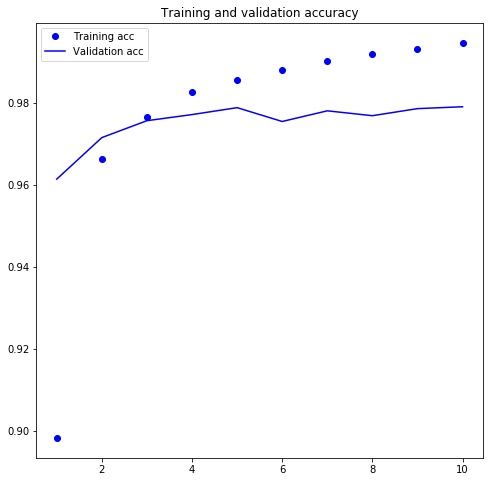

In [15]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

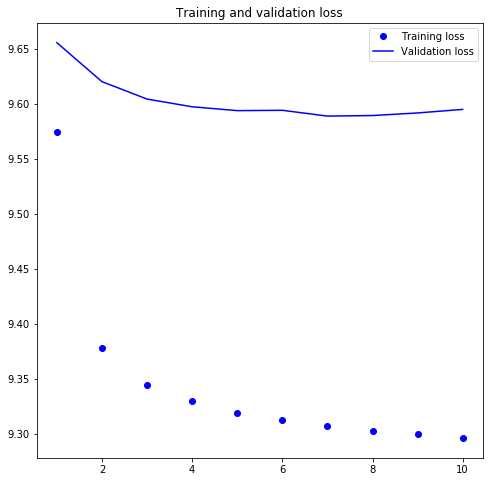

In [16]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
tsvfile=open("NCBI-disease-IOB/test.tsv",encoding="utf-8")
tsvreader = csv.reader(tsvfile, delimiter="\t")
data1=[]
sentences1=[]
words1=[]
tags1=[]
for line in tsvreader:
    if line!=[]:
        data1.append(line)
        if line[0] not in words1:
            words1.append(line[0])
        if line[1] not in tags1:
            tags1.append(line[1])
    else:
        sentences1.append(data1)
        data1=[]

X1 = [[word_to_index[w[0] if w[0] in words else "UNK"] for w in s] for s in sentences1]
print(X1[0],X1[1])
count=0
for s in sentences1:
    print(s)
    count=count+1
    if count>5:
        break
# Padding each sequence to have same length  of each word
X1 = pad_sequences(maxlen = max_len, sequences = X1, padding = "post", value = word_to_index["PAD"])
y1 = [[tag_to_index[w[1]] for w in s] for s in sentences1]
print(y1[0])
# padding
y1 = pad_sequences(maxlen = max_len, sequences = y1, padding = "post", value = tag_to_index["PAD"])
num_tag = 3
print(num_tag)
# One hot encoded labels
y1=[to_categorical(i, num_classes = num_tag + 1) for i in y1]

[1, 3, 532, 219, 52, 8, 2065, 19, 2066, 135, 52, 6, 696, 145, 19, 489, 1, 14] [3270, 19, 2066, 16, 116, 19, 145, 18, 285, 6, 509, 5404, 19, 1024, 789, 1251, 25, 219, 52, 8, 2067, 135, 146, 5336, 19, 1, 16, 4407, 14, 108, 18, 14]
[['Clustering', 'O'], ['of', 'O'], ['missense', 'O'], ['mutations', 'O'], ['in', 'O'], ['the', 'O'], ['ataxia', 'B-Disease'], ['-', 'I-Disease'], ['telangiectasia', 'I-Disease'], ['gene', 'O'], ['in', 'O'], ['a', 'O'], ['sporadic', 'B-Disease'], ['T', 'I-Disease'], ['-', 'I-Disease'], ['cell', 'I-Disease'], ['leukaemia', 'I-Disease'], ['.', 'O']]
[['Ataxia', 'B-Disease'], ['-', 'I-Disease'], ['telangiectasia', 'I-Disease'], ['(', 'O'], ['A', 'B-Disease'], ['-', 'I-Disease'], ['T', 'I-Disease'], [')', 'O'], ['is', 'O'], ['a', 'O'], ['recessive', 'B-Disease'], ['multi', 'I-Disease'], ['-', 'I-Disease'], ['system', 'I-Disease'], ['disorder', 'I-Disease'], ['caused', 'O'], ['by', 'O'], ['mutations', 'O'], ['in', 'O'], ['the', 'O'], ['ATM', 'O'], ['gene', 'O'], ['at

In [18]:
y_pred = model.predict(X1)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y1, -1)

In [19]:
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [20]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 86.6%


In [21]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

   B-Disease       0.82      0.72      0.77       960
   I-Disease       0.84      0.72      0.77      1087
           O       0.98      0.99      0.98     22441
         PAD       1.00      1.00      1.00    105094

    accuracy                           0.99    129582
   macro avg       0.91      0.86      0.88    129582
weighted avg       0.99      0.99      0.99    129582



In [22]:
TP=0
TN=0
FP=0
FN=0
i=0
nument=0
while i<len(y_test_true):
    j=0
    #print(i)
    while j <len(y_test_true[i]):
        #print('j ',j)
        if y_test_true[i][j]=='B-Disease':
            st=j
            nument=nument+1
            j=j+1
            while (y_test_true[i][j]=='I-Disease' or y_test_true[i][j]=='E-Disease') and j<len(y_test_true[i]):
                j=j+1
                #print('inside ',j)
            end=j
            if y_test_true[i][st:end]==y_pred[i][st:end]:
                TP=TP+1
            else:
                FN=FN+1
        elif y_test_true[i][j]=='O' and y_pred[i][j]=='O':
            TN=TN+1
            
        elif y_test_true[i][j]=='O' and y_pred[i][j]!='O':
            FP=FP+1
            
        j=j+1
        
    i=i+1
    
Precision=TP/(TP+FP)
print(Precision)
Recall=TP/(TP+FN)
print(Recall)
F1=(2*Precision*Recall)/(Precision+Recall)
print(F1)
mat=[[TP,FP],[FN,TN]]
print(mat)

0.7548240635641317
0.6963350785340314
0.7244008714596951
[[665, 216], [290, 21278]]


In [23]:
TP=0
TN=0
FP=0
FN=0
i=0
nument=0
while i<len(y_test_true):
    j=0
    #print(i)
    while j <len(y_test_true[i]):
        #print('j ',j)
        if y_test_true[i][j]=='B-Disease':
            st=j
            nument=nument+1
            j=j+1
            while (y_test_true[i][j]=='I-Disease' or y_test_true[i][j]=='E-Disease') and j<len(y_test_true[i]):
                j=j+1
                #print('inside ',j)
            end=j
            found=0
            for k in range(st,end):
                if y_test_true[i][k]==y_pred[i][k]:
                    found=1
                    break
            if found==1:
                TP=TP+1
            else:
                FN=FN+1
            '''if y_test_true[i][st:end]==y_pred[i][st:end]:
                TP=TP+1'''
            
        elif y_test_true[i][j]=='O' and y_pred[i][j]=='O':
            TN=TN+1
            
        elif y_test_true[i][j]=='O' and y_pred[i][j]!='O':
            FP=FP+1
            
        j=j+1
        
    i=i+1
    
Precision=TP/(TP+FP)
print(Precision)
Recall=TP/(TP+FN)
print(Recall)
F1=(2*Precision*Recall)/(Precision+Recall)
print(F1)
mat=[[TP,FP],[FN,TN]]
print(mat)

0.7711864406779662
0.762303664921466
0.7667193259610321
[[728, 216], [227, 21278]]
